# Exercise 13

## Analyze class homeworks


In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

data = pd.read_excel('https://github.com/albahnsen/AdvancedMethodsDataAnalysisClass/raw/master/datasets/Consolidado_respuestas_escribir_v2.xlsx', encoding='UTF-8')
data.head(3)


,Genero,E1 - Examples of Time Series Analysis,E4 - Panel Data,E6 - Decison Trees,E8 - Ensemble Trees Overview,E10 - REST-API,E11 - Natural Language Processing Overview
0,M,One of the most valuable application of time s...,The main difference between panel data and tim...,Decision tree are a model used by the analytic...,They are used to make a better prediction than...,Es una forma de arquitectura de datos. Los mic...,NaN
1,F,ANÁLISIS DE SERIES DE TIEMPO – USOS \nEl análi...,Series de Tiempo vs Datos en Panel\nUna serie ...,TIPOS DE ÁRBOLES DE DECISIÓN Y APLICACIONES\nL...,ENSAMBLAJE EN MACHINE LEARNING\nLos métodos de...,Microservicios\nEl objetivo principal de la im...,NaN
2,M,Una serie de tiempo es una colección de datos ...,NaN,los arboles de decisión hacen parte de los alg...,Ensemble methods is a machine learning techniq...,El enfoque tradicional para el diseño de aplic...,"LexisNexis launched Lexis Analytics, a legal r..."


# Exercise 13.1

Analyze the writing patterns of each student

**Descripción de la data**: La tabla continene información de 6 tareas de los 46 estudiantes de Modelos 1, donde el 21.7% son mujeres y el 78.26% son hombres. Las columnas conforman las tareas y se encuentra que la tarea menos realizada fue la E11 (NLP). En general, se tienen Missing value en todas las col

In [2]:
data.isnull().sum()

Genero                                         0
E1 - Examples of Time Series Analysis          2
E4 - Panel Data                                2
E6 - Decison Trees                             4
E8 - Ensemble Trees Overview                   8
E10 - REST-API                                 1
E11 - Natural Language Processing Overview    30
dtype: int64

In [3]:
data['Genero'].value_counts()/46*100

M    78.26087
F    21.73913
Name: Genero, dtype: float64

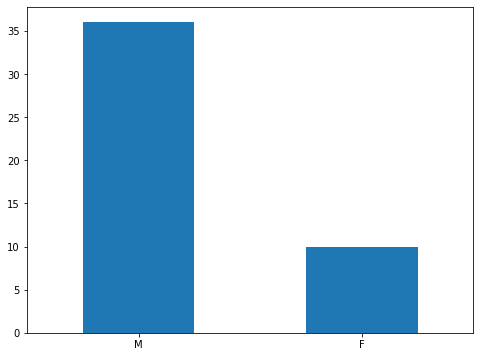

In [4]:
pd.Series(data["Genero"]).value_counts().plot(kind = "bar",figsize=(8,6),rot = 0);

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier as RFC
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.tree import DecisionTreeClassifier

In [6]:
data =data.rename(columns={"E1 - Examples of Time Series Analysis": "E1",
                     "E4 - Panel Data": "E4", 
                     "E6 - Decison Trees":"E6",
                     "E8 - Ensemble Trees Overview":"E8", 
                     "E10 - REST-API":"E10",
                     "E11 - Natural Language Processing Overview": "E11"});

### Traducción de los textos de español a inglés


Inicialmente realizamos la traducción de los texto de inglés a español pero el diccionario de stopwords no consideramos que era el mejor. De manera que para mejorar la calidad del análisis preferimos la traducción de español a inglés. 


In [7]:
#!pip install googletrans;

In [8]:
import pandas as pd
import googletrans
from googletrans import Translator
translator = Translator()

In [9]:
# listado de idiomas
lang_df = pd.DataFrame.from_dict(googletrans.LANGUAGES,  orient='index', columns=['Language'])
lang_df[lang_df.Language.isin(['english', 'spanish'])] # podemos ver los términos para llamar los idiomas que nos interesan

,Language
en,english
es,spanish


In [10]:
 # quitamos los caracteres especiales en toda la data
cols = ['E1', 'E4', 'E6', 'E8', 'E10', 'E11']
data[cols] = data[cols].replace('[)°<&/*\n\t0123456789=,.:–(]','', regex=True)

In [11]:
data=data.fillna('_') # para que la traducción se logre reemplazamos temporalmente los espacios en blanco por un _
data.head(2)

,Genero,E1,E4,E6,E8,E10,E11
0,M,One of the most valuable application of time s...,The main difference between panel data and tim...,Decision tree are a model used by the analytic...,They are used to make a better prediction than...,Es una forma de arquitectura de datos Los micr...,_
1,F,ANÁLISIS DE SERIES DE TIEMPO USOS El análisis...,Series de Tiempo vs Datos en PanelUna serie de...,TIPOS DE ÁRBOLES DE DECISIÓN Y APLICACIONESLos...,ENSAMBLAJE EN MACHINE LEARNINGLos métodos de e...,MicroserviciosEl objetivo principal de la impl...,_


In [12]:
#realizamos la traducción de todas la columnas pasar a español
data['E1'] = data['E1'].apply(translator.translate,src='en',dest='es').apply(getattr, args=('text',))
data['E4'] = data['E4'].apply(translator.translate,src='en',dest='es').apply(getattr, args=('text',))
data['E6'] = data['E6'].apply(translator.translate,src='en',dest='es').apply(getattr, args=('text',))
data['E8'] = data['E8'].apply(translator.translate,src='en',dest='es').apply(getattr, args=('text',))
data['E10'] = data['E10'].apply(translator.translate,src='en',dest='es').apply(getattr, args=('text',))
data['E11'] = data['E11'].apply(translator.translate,src='en',dest='es').apply(getattr, args=('text',))


In [13]:
# se unifican las tareas en la columna union para hacer el análisis a nivel de estudiante
data['union'] = data[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
data.head(2)

,Genero,E1,E4,E6,E8,E10,E11,union
0,M,Una de las aplicaciones más valiosas del análi...,La principal diferencia entre los datos del pa...,El árbol de decisión es un modelo utilizado po...,Se utilizan para hacer una mejor predicción qu...,Es una forma de arquitectura de datos Los micr...,_ _,Una de las aplicaciones más valiosas del análi...
1,F,ANÁLISIS DE SERIES DE TIEMPO USOS El análisis ...,Serie de Tiempo vs Datos en PanelUna serie de ...,TIPOS DE ÁRBOLES DE DECISIÓN Y APLICACIONESLos...,ENSAMBLAJE EN APRENDIZAJE DE MÁQUINAS Los méto...,MicroserviciosEl objetivo principal de la impl...,_ _,ANÁLISIS DE SERIES DE TIEMPO USOS El análisis ...


##### Ajustamos la data removiendo puntuación, aplicando stopwords, lematización, etc.

In [14]:
df=data['union']

In [15]:
def remove_punctuation(text):
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [16]:
df = df.apply(remove_punctuation)
df.head() # se han eliminado expresiones como el @ y '

0    Una de las aplicaciones más valiosas del análi...
1    ANÁLISIS DE SERIES DE TIEMPO USOS El análisis ...
2    Una serie de tiempo es una colección de datos ...
3    Dado que el análisis de series de tiempo permi...
4    El análisis de series temporales se refiere al...
Name: union, dtype: object

In [17]:
#! pip install nltk
#!pip install lemma
#!pip install Pattern3

In [18]:
import nltk
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
#from pattern.es import lemma
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
# define una función que acepta texto y retorna una lista de lemas
def split_into_lemmas(text):
    text = text.lower()
    words = text.split()
    return [wordnet_lemmatizer.lemmatize(word) for word in words]

In [20]:
stemmer = SnowballStemmer('spanish')

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

In [21]:
df = df.apply(stemming) # se dejan las raices de las palabras

In [23]:
sw = stopwords.words('spanish')  #  este es el listado de stopwords en español
np.array(sw)
print("Number of stopwords: ", len(sw)) # este es el número de stopwords en español

Number of stopwords:  313


In [24]:
# A lista actual de stop words le agregamos otras palabras que consideramos no contribuyen en el ánalisis
my_additional_stop_words = ["uso", "usos", "trata", "política", "siguientes", "vale", "pena", "IPC", "ejemplos", "brevemente", "cada", "puede", "pueden", "si", "ser",
                            "solo", "través", "tipo", "cuales"]
spanish_stopwords = stopwords.words('spanish')
spanish_stopwords
spanish_stopwords= spanish_stopwords+my_additional_stop_words
spanish_stopwords;


In [25]:
vect = CountVectorizer(stop_words=spanish_stopwords, ngram_range=(1, 2))
#vect = CountVectorizer(analyzer=split_into_lemmas,stop_words=stopwords.words('spanish'), ngram_range=(1, 3))
X_dtm = vect.fit_transform(df)
temp = X_dtm.todense()
temp.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ipc'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(46, 28490)

### La siguiente gráfica muestra las palabras más frecuentes en toda la data

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


FrequencyVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f268cdca278>,
                    color=None,
                    features=['ab', 'ab raftery', 'abaj', 'abaj cad',
                              'abaj enfoqu', 'abaj form', 'abaj general',
                              'abaj traves', 'abarc', 'abarc camp', 'abarqu',
                              'abarqu resuelv', 'abastec', 'abastec diferent',
                              'abiert', 'abiert camin', 'abiert deb',
                              'abiert microservici', 'abil', 'abil person',
                              'abord', 'abord analisis', 'abord diferent',
                              'abord problem', 'abord solucion', 'abord vez',
                              'abordaj', 'abordaj estrategi', 'abran',
                              'abran model', ...],
                    n=None, orient='v')

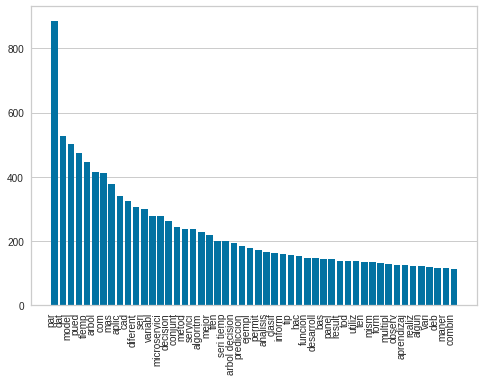

In [26]:
#!pip install yellowbrick
from yellowbrick.text import FreqDistVisualizer;
features   = vect.get_feature_names()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(X_dtm)
#visualizer.show();

### Función 'linea' - Palabras por estudiante
Esta función nos permite ver graficamente las 10 palabras más frecuente utilizadas por un estudiante. 

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ipc'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


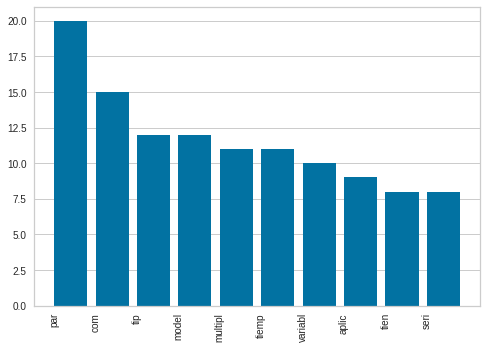

In [27]:
def linea (i):
    estudiante = df[[i]]
    vect = CountVectorizer(stop_words=spanish_stopwords, ngram_range=(1, 3))
    X_dtm = vect.fit_transform(estudiante)
    features   = vect.get_feature_names()
    visualizer = FreqDistVisualizer(features=features,n=10, orient='v')
    visualizer.fit(X_dtm)
    #visualizer.show()
    
linea(12) # se indica el número de fila del estudiante
   

# Exercise 13.2

Evaluate the similarities of the homeworks of the students.

At a homework level, then as a student level.

In [28]:
import numpy as np; import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

### Análisis tarea E1.

In [29]:
E1 = data['E1']
E1 = E1.dropna() # se eleminan NA, entonces se debe ser cuidadoso entre el índice y la posición de la matriz de similaridad
E1;

In [30]:
vect = CountVectorizer(stop_words=spanish_stopwords, max_features=1000) # por default pasa todas las palablas a minuscula (lowercase)
E1_dtm = vect.fit_transform(E1)
temp=E1_dtm.todense()
temp.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ipc'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(46, 1000)

In [31]:
#muestra todas las combianciones del coseno de similaridad de las tareas E1 para los 44 estudiantes que la presentaron
cs_E1 = cosine_similarity(temp,temp)  #esta es una matriz simetrica de similaridad del coseno
cs_E1.shape

(46, 46)

In [32]:
# Dado que la matriz anterior es simétrica, entonces es suficiente con seleccionar la matriz triangular inferior 
import numpy
tri_lower_no_diag = np.tril(cs_E1, k=-1)# matriz triangular inferior
tri_lower_no_diag

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.22926455, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.30136622, 0.26105345, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.22645541, 0.31618182, 0.2892233 , ..., 0.        , 0.        ,
        0.        ],
       [0.21719083, 0.27790204, 0.22398975, ..., 0.27572238, 0.        ,
        0.        ],
       [0.33245071, 0.15962172, 0.30141157, ..., 0.27071755, 0.18236561,
        0.        ]])

In [33]:
maxElement = numpy.amax(tri_lower_no_diag)
print('El coseno de similaridad más alto entre dos estudiantes : ', maxElement)

El coseno de similaridad más alto entre dos estudiantes :  0.49531088096035586


In [34]:
resultE1 = numpy.where(tri_lower_no_diag == numpy.amax(tri_lower_no_diag))
listOfCordinates = list(zip(resultE1[0], resultE1[1]))
for cord in listOfCordinates:
    print('Posiciones de la matriz con el mayor coseno de similaridad : ', cord)

Posiciones de la matriz con el mayor coseno de similaridad :  (40, 2)


In [35]:
#Estás son las dos respuestas más parecidas de la tarea E1
Estudiantes_E1=E1.loc[E1.index[[34,16]]]
Estudiantes_E1

34    Los siguientes corresponden a ejemplos de las ...
16    Casos Reales del Análisis de Series de TiempoU...
Name: E1, dtype: object

#### Función tareas
A continuación, se presentan la funicón tareas que nos permite identificar los dos estuadiantes con las tareas más similares. 


In [36]:
def tareas(i):
    E = data[i]
    E = E.dropna()

    vect = CountVectorizer(stop_words=spanish_stopwords, ngram_range=(1, 2), lowercase=True) 
    E_dtm = vect.fit_transform(E)
    temp= E_dtm.todense()

    cs_E = cosine_similarity(temp)
    Etri_lower_no_diag = np.tril(cs_E, k=-1)# matriz triangular inferior
    EmaxElement = numpy.amax(Etri_lower_no_diag)
    posicion = numpy.where(Etri_lower_no_diag == numpy.amax(Etri_lower_no_diag))
    df_posicion = pd.DataFrame(posicion)
    Estudiantes = E.loc[E.index[[df_posicion[0][0] , df_posicion[0][1]]]]

    print('Las siguientes son las tareas más parecidas por su coseno de similaridad: ', Estudiantes,  EmaxElement)

       # print('Los dos estudiantes más similares en esta tarea son : ', Estudiantes)

In [37]:
tareas('E10') # Indicamos el nombre de la tarea


Las siguientes son las tareas más parecidas por su coseno de similaridad:  42    MicroserviciosEs una funcionalidad empresarial...
27    Los microservicios son un enfoque arquitectóni...
Name: E10, dtype: object 0.5460108411983262


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ipc'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


# Exercise 13.3

Create a classifier to predict the gender of each student



In [38]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier as RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.tree import DecisionTreeClassifier

In [39]:
X1=data['union']
y = data[['Genero']]
y['Genero'] = pd.factorize(data.Genero)[0]
X1.shape, y.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


((46,), (46, 1))

In [40]:
X1 = X1.apply(remove_punctuation)

In [41]:
X1 = X1.apply(stemming)

In [42]:
vectF = TfidfVectorizer(stop_words=spanish_stopwords, ngram_range=(1, 2), min_df=0.1, max_df=0.9) # indicamos los valores min y max del tfidf
X_dtmF = vectF.fit_transform(X1)
tempF = X_dtmF.todense()
tempF

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ipc'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.03617688, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.03646693, 0.        , ..., 0.        , 0.        ,
         0.03840251],
        [0.        , 0.03786934, 0.07975872, ..., 0.        , 0.08126998,
         0.        ]])

In [43]:
dataF = pd.DataFrame(tempF, columns=vectF.get_feature_names())# almacena la tabla después del tfidf

In [44]:
mdl = RandomForestClassifier(n_estimators=10, max_depth=50)
print("El accuracy de este modelos es: ", np.mean(cross_val_score(mdl, dataF, y, cv=5)))


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


El accuracy de este modelos es:  0.7822222222222222


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


# Exercise 13.4
Classify group members into different subgroups (minimum 3) according to a characteristic of your choice.

### Dendrograma

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from matplotlib.pyplot import figure
from sklearn import preprocessing
import pandas as pd
from scipy.cluster import hierarchy
import numpy as np

In [46]:
vectF = CountVectorizer(stop_words=spanish_stopwords, ngram_range=(1, 2), max_features=100) 
X_dtmF = vectF.fit_transform(X1)
tempF = X_dtmF.todense()
dataF = pd.DataFrame(tempF, columns=vectF.get_feature_names())

dataF.head(2)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ipc'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,afect,aleatori,algoritm,algun,analisis,aplic,aprendizaj,arbol,arbol decision,arquitectur,automat,bas,cad,caracterist,cas,clasif,com,combin,component,comport,conjunt,constru,cre,cuand,dat,dat panel,deb,decision,desarroll,diferent,dond,ejempl,ensamblaj,entren,especif,exist,facil,form,funcion,gener,...,obten,panel,par,part,per,period,permit,pod,posibl,predec,prediccion,principal,problem,proces,product,pued,realiz,regresion,result,seri,seri tiemp,servici,sistem,sobr,softwar,sol,tambien,tecnic,ten,tiemp,tien,tip,tod,tom,traves,utiliz,valor,vari,variabl,vent
0,0,4,2,9,5,11,1,12,6,1,1,3,9,0,1,0,7,1,1,1,4,0,1,4,14,2,7,11,1,7,0,2,0,0,1,0,1,6,2,1,...,1,2,24,3,0,1,3,2,2,2,6,3,2,2,1,2,0,1,3,7,4,2,1,2,0,3,3,7,1,7,3,1,4,1,0,7,5,2,5,3
1,1,0,1,4,4,9,3,11,5,1,1,2,2,1,2,2,11,3,5,2,2,2,4,3,8,0,2,7,4,2,0,2,6,1,1,1,6,0,0,2,...,5,1,22,3,4,7,12,0,1,0,3,4,1,2,3,14,10,3,5,11,7,1,0,5,0,0,1,2,5,11,5,4,2,3,0,1,6,2,7,6


Con el dendograma (utilizando distancia euclideana) podemos identificar 3 **grupos de estudiantes**, demarcados por la línea horizontal al gráfico.
Los tres grupos de estudiantes y sus etiquetas, obtenidos utilizando  el dendograma y el AgglomerativeClustering son: 
Grupo 1: 29,9,31,8 y 13
Grupo 2: 16, 30, 4, 3, 38
Gropo 0: los restantes

In [50]:
X= dataF
pd.DataFrame(X.columns)
X = X.iloc[:, 1:].values
X = preprocessing.scale(X) # Se re escalan las variables

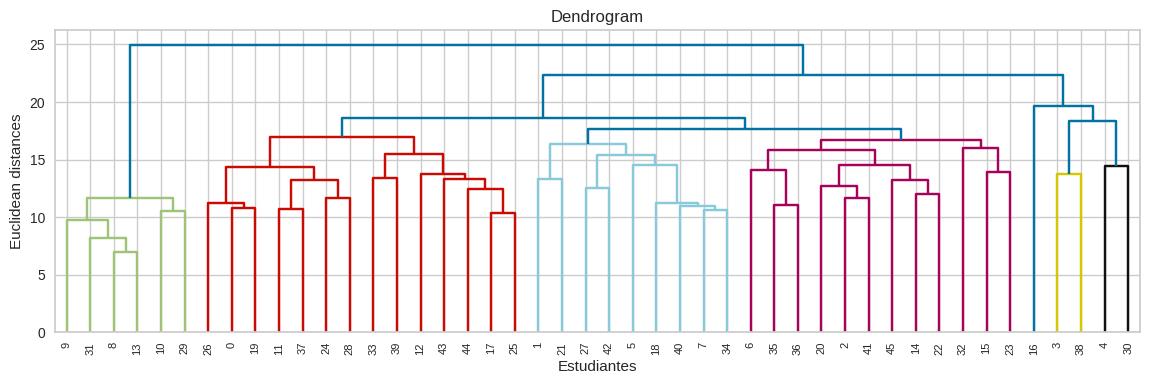

In [51]:
figure(num=None, figsize=(14, 4), dpi=100, facecolor='w', edgecolor='k')
dendrogram = sch.dendrogram(sch.linkage(X, method  = "ward"))
plt.axhline(y=65, color='y', linestyle='--')
plt.title('Dendrogram')
plt.xlabel('Estudiantes')
plt.ylabel('Euclidean distances')
plt.show()

Ahora, queremos agrupar los puntos de datos en estos tres clústeres. Para hacerlo, utilizaremos AgglomerativeClustering

In [52]:
# Ajustando Clustering Jerárquico al conjunto de datos
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X)
y_hc #muestra las tres etiquetas de datos de los grupos

array([2, 2, 2, 0, 0, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 2])

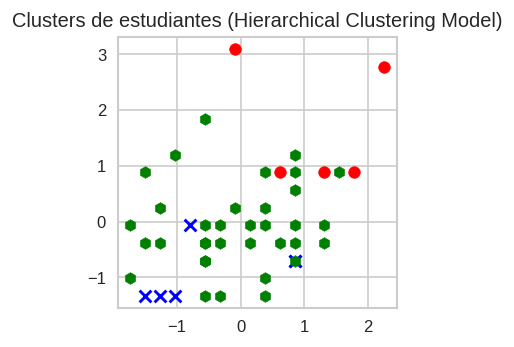

In [53]:
#se visualizan los tres grupos de estudiantes similares según las palabras utilizadas por ellos
eje_x = 4
eje_y = 7
figure(num=None, figsize=(3, 3), dpi=120, facecolor='w', edgecolor='k')
plt.scatter(X[y_hc==0, eje_x], X[y_hc==0, eje_y], s=50, c='red', label ='Cluster 1', marker='o')
plt.scatter(X[y_hc==1, eje_x], X[y_hc==1, eje_y], s=50, c='blue', label ='Cluster 2',marker='x')
plt.scatter(X[y_hc==2, eje_x], X[y_hc==2, eje_y], s=50, c='green', label ='Cluster 3',marker='h')
plt.title('Clusters de estudiantes (Hierarchical Clustering Model)')
plt.show()
